In [1]:
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

In [2]:
import os
import h5py
import regex
import numpy as np

In [3]:
from scipy.interpolate import griddata

In [4]:
from crystfel_stream_parser.engine import StreamParser

In [5]:
path_stream = 'userdata/cxic0415/cwang31/psocake/r0101/cxic0415_0101.stream'
stream_parser = StreamParser(path_stream)

In [6]:
stream_record_dict = stream_parser.parse(num_cpus = 10)

2024-03-06 17:14:27,657	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [7]:
basedir = 'userdata'
chunk_block = stream_record_dict[1]['CHUNK_BLOCK']
path_cxi = os.path.join(basedir, chunk_block['metadata']['Image filename'])
cxi_event_idx = int(os.path.join(basedir, chunk_block['metadata']['Event'])[2:])

In [21]:
path_cxi,cxi_event_idx

('userdata/./cxic0415/cwang31/psocake/r0101/cxic0415_0101_train.cxi', 13)

In [38]:
def display_img(img):
    ncols, nrows = 1, 1
    scale        = 14
    fig   = plt.figure(figsize = (ncols * scale, nrows * scale))
    gspec = fig.add_gridspec( nrows, ncols )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    ax = ax_list[0]

    vmin = np.nanmean(img) - 0 * np.nanstd(img)
    vmax = np.nanmean(img) + 4 * np.nanstd(img)
    im = ax.imshow(img, vmin = vmin, vmax = vmax)

In [9]:
with h5py.File(path_cxi, 'r') as f:
    psana_event_idx = f.get('LCLS/eventNumber')[cxi_event_idx]
    cxi_img = f.get('entry_1/data_1/data')[cxi_event_idx]

In [104]:
psana_event_idx

36

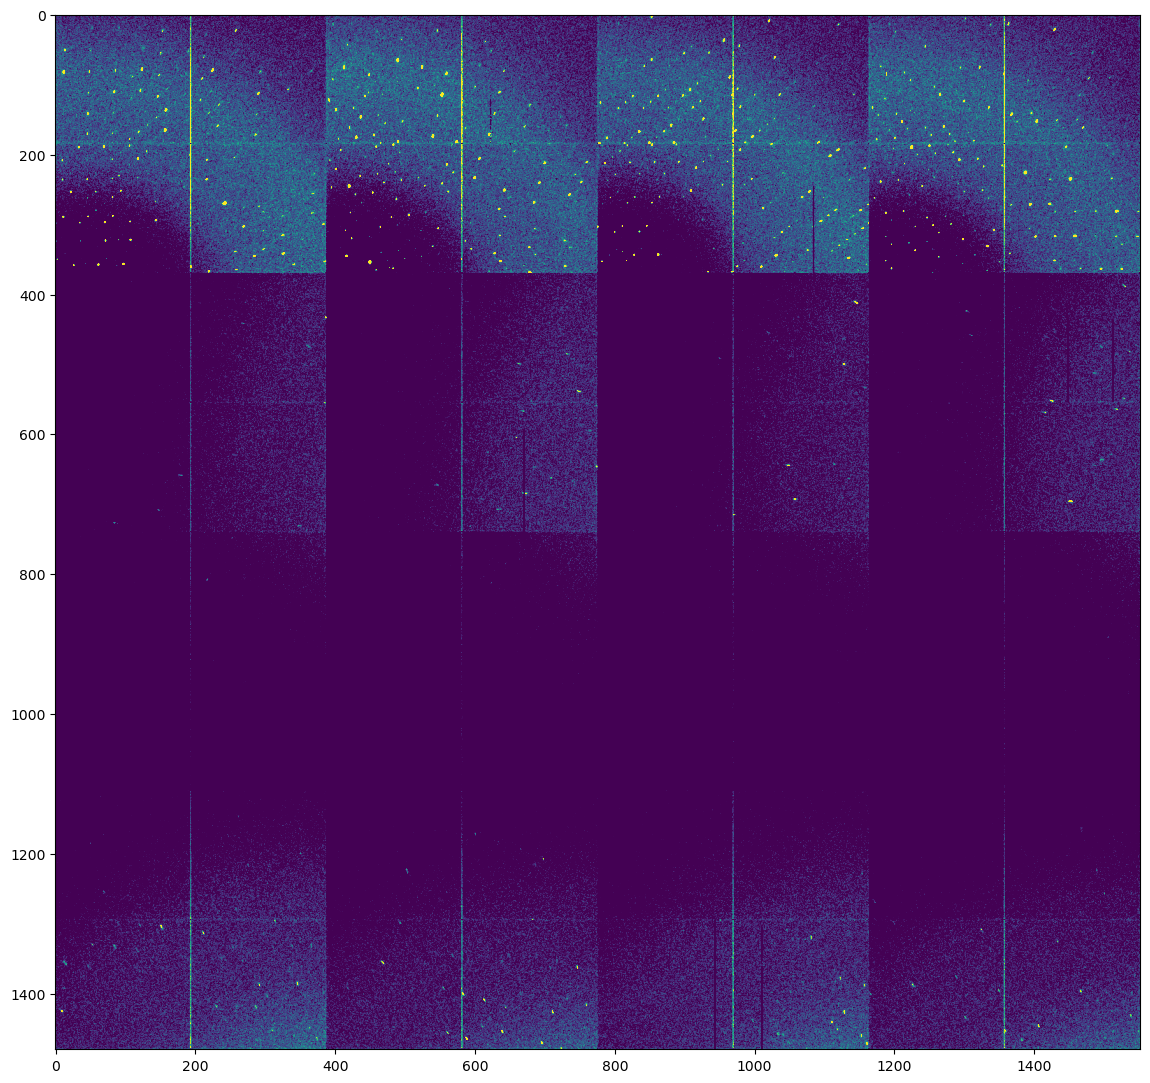

In [10]:
display_img(cxi_img)

In [40]:
cxi_img.shape

(1480, 1552)

In [60]:
print('''
  'q0a0/min_fs': '0',
  'q0a0/min_ss': '0',
  'q0a0/max_fs': '193',
  'q0a0/max_ss': '184',
  'q0a0/fs': '+0.006140x +0.999981y',
  'q0a0/ss': '-0.999981x +0.006140y',
  'q0a0/corner_x': '444.963365',
  'q0a0/corner_y': '-45.414341',
  'q0a0/coffset': '0.5886982000000001',
''')


  'q0a0/min_fs': '0',
  'q0a0/min_ss': '0',
  'q0a0/max_fs': '193',
  'q0a0/max_ss': '184',
  'q0a0/fs': '+0.006140x +0.999981y',
  'q0a0/ss': '-0.999981x +0.006140y',
  'q0a0/corner_x': '444.963365',
  'q0a0/corner_y': '-45.414341',
  'q0a0/coffset': '0.5886982000000001',



In [131]:
class CheetahConverter:

    def __init__(self, geom_block):
        self.geom_block = geom_block

        panel_minmax_pattern = regex.compile(
        r"""(?x)
        # Match the pattern below
        (?> (?&DET_PANEL) / ) (?&COORD)
        \s = \s    # Match a equal sign with blank spaces on both sides
        (?&VALUE)  # Match the value of the coordinate

        (?(DEFINE)
            (?<DET_PANEL>
                [0-9a-zA-Z]+
            )
            (?<COORD>
                (?:min_fs)
            |   (?:min_ss)
            |   (?:max_fs)
            |   (?:max_ss)
            )
            (?<VALUE> [0-9]+)
        )
        """)

        panel_orient_pattern = regex.compile(
            r"""(?x)
            # Match the pattern below
            (?> (?&DET_PANEL) / ) (?&COORD)
            \s = \s    # Match a equal sign with blank spaces on both sides
            (?&VALUE_X) x \s (?&VALUE_Y) y  # Match the value of the coordinate

            (?(DEFINE)
                (?<DET_PANEL>
                    [0-9a-zA-Z]+
                )
                (?<COORD>
                    (?:fs)
                |   (?:ss)
                )
                (?<VALUE_X> 
                    [-+]?         # Match a sign
                    (?>\d+)       # Match integer part
                    (?:\.\d*)?    # Match decimal part
                )
                (?<VALUE_Y> 
                    [-+]?         # Match a sign
                    (?>\d+)       # Match integer part
                    (?:\.\d*)?    # Match decimal part
                )
            )
            """)

        panel_corner_pattern = regex.compile(
            r"""(?x)
            # Match the pattern below
            (?> (?&DET_PANEL) / ) (?&COORD)
            \s = \s    # Match a equal sign with blank spaces on both sides
            (?&VALUE)  # Match the value of the coordinate

            (?(DEFINE)
                (?<DET_PANEL>
                    [0-9a-zA-Z]+
                )
                (?<COORD>
                    (?:corner_x)
                |   (?:corner_y)
                )
                (?<VALUE> 
                    [-+]?         # Match a sign
                    (?>\d+)       # Match integer part
                    (?:\.\d*)?    # Match decimal part
                )
            )
            """)

        # Go through each line...
        geom_dict = {
            'panel_minmax' : {},
            'panel_orient' : {},
            'panel_corner' : {},
        }
        for geom_key, geom_value in geom_block.items():
            line = f"{geom_key} = {geom_value}"

            # Match a geom object...
            m = panel_minmax_pattern.match(line)
            if m is not None:
                # Fetch values...
                capture_dict = m.capturesdict()
                panel = capture_dict['DET_PANEL'][0]
                coord = capture_dict['COORD'][0]
                value = capture_dict['VALUE'][0]

                # Save values...
                if not panel in geom_dict['panel_minmax']:
                    geom_dict['panel_minmax'][panel] = {
                        'min_fs' : None,
                        'min_ss' : None,
                        'max_fs' : None,
                        'max_ss' : None,
                    }
                geom_dict['panel_minmax'][panel][coord] = int(value)
            
            # Match a geom object...
            m = panel_orient_pattern.match(line)
            if m is not None:
                # Fetch values...
                capture_dict = m.capturesdict()
                panel = capture_dict['DET_PANEL'][0]
                coord = capture_dict['COORD'][0]
                val_x = capture_dict['VALUE_X'][0]
                val_y = capture_dict['VALUE_Y'][0]

                # Save values...
                if not panel in geom_dict['panel_orient']:
                    geom_dict['panel_orient'][panel] = {
                        'fs' : None,
                        'ss' : None,
                    }
                geom_dict['panel_orient'][panel][coord] = (float(val_y), float(val_x))
            
            # Match a geom object...
            m = panel_corner_pattern.match(line)
            if m is not None:
                # Fetch values...
                capture_dict = m.capturesdict()
                panel = capture_dict['DET_PANEL'][0]
                coord = capture_dict['COORD'][0]
                value = capture_dict['VALUE'][0]

                # Save values...
                if not panel in geom_dict['panel_corner']:
                    geom_dict['panel_corner'][panel] = {
                        'corner_x' : None,
                        'corner_y' : None,
                    }
                geom_dict['panel_corner'][panel][coord] = float(value)

        idx_to_panel = {}
        panel_to_idx = {}
        cheetah2psana_geom_dict = {}
        for panel_idx, (panel_str, panel_minmax) in enumerate(geom_dict['panel_minmax'].items()):
            x_min = panel_minmax['min_fs']
            y_min = panel_minmax['min_ss']
            x_max = panel_minmax['max_fs']
            y_max = panel_minmax['max_ss']

            x_max += 1
            y_max += 1

            # panel_key = (panel_idx, panel_str)
            idx_to_panel[panel_idx] = panel_str
            panel_to_idx[panel_str] = panel_idx
            panel_key = panel_str
            if panel_key not in cheetah2psana_geom_dict: cheetah2psana_geom_dict[panel_key] = [x_min, y_min, x_max, y_max]
            panel_x_min, panel_y_min, panel_x_max, panel_y_max = cheetah2psana_geom_dict[panel_key]
            panel_x_min = min(panel_x_min, x_min)
            panel_y_min = min(panel_y_min, y_min)
            panel_x_max = max(panel_x_max, x_max)
            panel_y_max = max(panel_y_max, y_max)
            cheetah2psana_geom_dict[panel_key] = panel_x_min, panel_y_min, panel_x_max, panel_y_max

        self.geom_dict    = geom_dict
        self.idx_to_panel = idx_to_panel
        self.panel_to_idx = panel_to_idx
        self.cheetah2psana_geom_dict = cheetah2psana_geom_dict


    def convert_to_cheetah_img(self, img):
        W_cheetah, H_cheetah = list(self.cheetah2psana_geom_dict.values())[-1][-2:]
        cheetah_img = np.zeros((H_cheetah, W_cheetah), dtype = np.float32)

        # for (panel_idx, panel_str), (x_min, y_min, x_max, y_max) in enumerate(self.cheetah2psana_geom_dict.items()):
        for panel_str, (x_min, y_min, x_max, y_max) in self.cheetah2psana_geom_dict.items():
            H = y_max - y_min
            W = x_max - x_min
            panel_idx = self.panel_to_idx[panel_str]
            cheetah_img[y_min:y_max, x_min:x_max] = img[panel_idx, 0:H, 0:W]

        return cheetah_img


    def convert_to_psana_img(self, cheetah_img):
        # Figure out channel dimension...
        C = len(self.cheetah2psana_geom_dict)

        # Figure out spatial dimension...
        x_min, y_min, x_max, y_max = next(iter(self.cheetah2psana_geom_dict.values()))
        H = y_max - y_min
        W = x_max - x_min

        # Initialize a zero value image...
        img = np.zeros((C, H, W), dtype = np.float32)

        # for (panel_idx, panel_str), (x_min, y_min, x_max, y_max) in self.cheetah2psana_geom_dict.items():
        for panel_str, (x_min, y_min, x_max, y_max) in self.cheetah2psana_geom_dict.items():
            panel_idx = self.panel_to_idx[panel_str]
            img[panel_idx] = cheetah_img[y_min:y_max, x_min:x_max]

        return img


    def convert_to_cheetah_coords(self, peaks_psana_list):
        peaks_cheetah_list = [
            self.convert_to_cheetah_coord(idx_panel, y, x)
            for idx_panel, y, x in peaks_psana_list
        ]

        return peaks_cheetah_list


    def convert_to_cheetah_coord(self, idx_panel, y, x):
        panel_str = self.id_to_panel(idx_panel)
        x_min, y_min, x_max, y_max = self.cheetah2psana_geom_dict[panel_str]

        x += x_min
        y += y_min

        return idx_panel, y, x

In [101]:
geom_block

{'clen': ' /LCLS/detector_1/EncoderValue',
 'photon_energy': '/LCLS/photon_energy_eV',
 'res': '9097.52',
 'adu_per_eV': '0.00338',
 'data': '/entry_1/data_1/data',
 'dim0': '%',
 'dim1': 'ss',
 'dim2': 'fs',
 'mask': '/entry_1/data_1/mask',
 'mask_good': '0x0000',
 'mask_bad': '0xffff',
 'rigid_group_q0': 'q0a0,q0a1,q0a2,q0a3,q0a4,q0a5,q0a6,q0a7,q0a8,q0a9,q0a10,q0a11,q0a12,q0a13,q0a14,q0a15',
 'rigid_group_q1': 'q1a0,q1a1,q1a2,q1a3,q1a4,q1a5,q1a6,q1a7,q1a8,q1a9,q1a10,q1a11,q1a12,q1a13,q1a14,q1a15',
 'rigid_group_q2': 'q2a0,q2a1,q2a2,q2a3,q2a4,q2a5,q2a6,q2a7,q2a8,q2a9,q2a10,q2a11,q2a12,q2a13,q2a14,q2a15',
 'rigid_group_q3': 'q3a0,q3a1,q3a2,q3a3,q3a4,q3a5,q3a6,q3a7,q3a8,q3a9,q3a10,q3a11,q3a12,q3a13,q3a14,q3a15',
 'rigid_group_a0': 'q0a0,q0a1',
 'rigid_group_a1': 'q0a2,q0a3',
 'rigid_group_a2': 'q0a4,q0a5',
 'rigid_group_a3': 'q0a6,q0a7',
 'rigid_group_a4': 'q0a8,q0a9',
 'rigid_group_a5': 'q0a10,q0a11',
 'rigid_group_a6': 'q0a12,q0a13',
 'rigid_group_a7': 'q0a14,q0a15',
 'rigid_group_a8'

In [131]:
panel_minmax = regex.compile(
    r"""(?x)
    # Match the pattern below
    (?> (?&DET_PANEL) / ) (?&COORD)
    \s = \s    # Match a equal sign with blank spaces on both sides
    (?&VALUE)  # Match the value of the coordinate

    (?(DEFINE)
        (?<DET_PANEL>
            [0-9a-zA-Z]+
        )
        (?<COORD>
            (?:min_fs)
        |   (?:min_ss)
        |   (?:max_fs)
        |   (?:max_ss)
        )
        (?<VALUE> [0-9]+)
    )
    """)

panel_orient = regex.compile(
    r"""(?x)
    # Match the pattern below
    (?> (?&DET_PANEL) / ) (?&COORD)
    \s = \s    # Match a equal sign with blank spaces on both sides
    (?&VALUE_X) x \s (?&VALUE_Y) y  # Match the value of the coordinate

    (?(DEFINE)
        (?<DET_PANEL>
            [0-9a-zA-Z]+
        )
        (?<COORD>
            (?:fs)
        |   (?:ss)
        )
        (?<VALUE_X> 
            [-+]?         # Match a sign
            (?>\d+)       # Match integer part
            (?:\.\d*)?    # Match decimal part
        )
        (?<VALUE_Y> 
            [-+]?         # Match a sign
            (?>\d+)       # Match integer part
            (?:\.\d*)?    # Match decimal part
        )
    )
    """)

In [108]:
geom_block = stream_record_dict[1]['GEOM_BLOCK']

In [132]:
cheetah_converter = CheetahConverter(geom_block)

In [110]:
cheetah_converter.geom_dict['panel_minmax']

{'q0a0': {'min_fs': 0, 'min_ss': 0, 'max_fs': 193, 'max_ss': 184},
 'q0a1': {'min_fs': 194, 'min_ss': 0, 'max_fs': 387, 'max_ss': 184},
 'q0a2': {'min_fs': 0, 'min_ss': 185, 'max_fs': 193, 'max_ss': 369},
 'q0a3': {'min_fs': 194, 'min_ss': 185, 'max_fs': 387, 'max_ss': 369},
 'q0a4': {'min_fs': 0, 'min_ss': 370, 'max_fs': 193, 'max_ss': 554},
 'q0a5': {'min_fs': 194, 'min_ss': 370, 'max_fs': 387, 'max_ss': 554},
 'q0a6': {'min_fs': 0, 'min_ss': 555, 'max_fs': 193, 'max_ss': 739},
 'q0a7': {'min_fs': 194, 'min_ss': 555, 'max_fs': 387, 'max_ss': 739},
 'q0a8': {'min_fs': 0, 'min_ss': 740, 'max_fs': 193, 'max_ss': 924},
 'q0a9': {'min_fs': 194, 'min_ss': 740, 'max_fs': 387, 'max_ss': 924},
 'q0a10': {'min_fs': 0, 'min_ss': 925, 'max_fs': 193, 'max_ss': 1109},
 'q0a11': {'min_fs': 194, 'min_ss': 925, 'max_fs': 387, 'max_ss': 1109},
 'q0a12': {'min_fs': 0, 'min_ss': 1110, 'max_fs': 193, 'max_ss': 1294},
 'q0a13': {'min_fs': 194, 'min_ss': 1110, 'max_fs': 387, 'max_ss': 1294},
 'q0a14': {'mi

In [14]:
psana_img = cheetah_converter.convert_to_psana_img(cxi_img)

In [15]:
psana_img.shape

(64, 185, 194)

In [16]:
cheetah_converter.cheetah2psana_geom_dict.values()

dict_values([(0, 0, 194, 185), (194, 0, 388, 185), (0, 185, 194, 370), (194, 185, 388, 370), (0, 370, 194, 555), (194, 370, 388, 555), (0, 555, 194, 740), (194, 555, 388, 740), (0, 740, 194, 925), (194, 740, 388, 925), (0, 925, 194, 1110), (194, 925, 388, 1110), (0, 1110, 194, 1295), (194, 1110, 388, 1295), (0, 1295, 194, 1480), (194, 1295, 388, 1480), (388, 0, 582, 185), (582, 0, 776, 185), (388, 185, 582, 370), (582, 185, 776, 370), (388, 370, 582, 555), (582, 370, 776, 555), (388, 555, 582, 740), (582, 555, 776, 740), (388, 740, 582, 925), (582, 740, 776, 925), (388, 925, 582, 1110), (582, 925, 776, 1110), (388, 1110, 582, 1295), (582, 1110, 776, 1295), (388, 1295, 582, 1480), (582, 1295, 776, 1480), (776, 0, 970, 185), (970, 0, 1164, 185), (776, 185, 970, 370), (970, 185, 1164, 370), (776, 370, 970, 555), (970, 370, 1164, 555), (776, 555, 970, 740), (970, 555, 1164, 740), (776, 740, 970, 925), (970, 740, 1164, 925), (776, 925, 970, 1110), (970, 925, 1164, 1110), (776, 1110, 970, 12

In [17]:
x_min, y_min, x_max, y_max = 0, 0, 0, 0
for (x_min_in_panel, y_min_in_panel, x_max_in_panel, y_max_in_panel) in cheetah_converter.cheetah2psana_geom_dict.values():
    x_min = min(x_min, x_min_in_panel)
    y_min = min(y_min, y_min_in_panel)
    x_max = max(x_max, x_max_in_panel)
    y_max = max(y_max, y_max_in_panel)

In [18]:
x_min, y_min, x_max, y_max

(0, 0, 1552, 1480)

In [58]:
panel_corner = cheetah_converter.geom_dict['panel_corner']
panel_corner

{'q0a0': {'corner_x': 444.963365, 'corner_y': -45.414341},
 'q0a1': {'corner_x': 446.172944, 'corner_y': 151.581946},
 'q0a2': {'corner_x': 241.2072, 'corner_y': -44.495572},
 'q0a3': {'corner_x': 242.219582, 'corner_y': 152.501827},
 'q0a4': {'corner_x': 872.842503, 'corner_y': 344.607547},
 'q0a5': {'corner_x': 675.846629, 'corner_y': 345.882531},
 'q0a6': {'corner_x': 871.725692, 'corner_y': 139.699542},
 'q0a7': {'corner_x': 674.729358, 'corner_y': 140.90144},
 'q0a8': {'corner_x': 482.361283, 'corner_y': 772.794908},
 'q0a9': {'corner_x': 481.792349, 'corner_y': 575.79573},
 'q0a10': {'corner_x': 687.678587, 'corner_y': 772.803917},
 'q0a11': {'corner_x': 687.530246, 'corner_y': 575.803972},
 'q0a12': {'corner_x': 448.574989, 'corner_y': 753.897168},
 'q0a13': {'corner_x': 251.575951, 'corner_y': 754.512794},
 'q0a14': {'corner_x': 447.791419, 'corner_y': 545.037292},
 'q0a15': {'corner_x': 250.792518, 'corner_y': 545.695274},
 'q1a0': {'corner_x': 31.468282, 'corner_y': 442.15947

In [90]:
min_y_lab, max_y_lab, min_x_lab, max_x_lab = 0, 0, 0, 0
panel_orient = cheetah_converter.geom_dict['panel_orient']
panel_corner = cheetah_converter.geom_dict['panel_corner']
original_coords_list = []
lab_coords_list = []
pixel_value_list = []
for panel_idx, panel_img in enumerate(psana_img):
    panel_str = cheetah_converter.idx_to_panel[panel_idx]

    H, W = panel_img.shape
    pixel_value_list.extend(panel_img.flatten())

    y_range = np.arange(H)
    x_range = np.arange(W)
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    
    original_coords = np.array([y_coords.flatten(), x_coords.flatten()])    # (2, N)
    original_coords_list.extend(original_coords.transpose(1, 0))

    corner_x = panel_corner[panel_str]['corner_x']
    corner_y = panel_corner[panel_str]['corner_y']
    corner = np.array([corner_y, corner_x]).reshape(2, 1)

    ss_orient = panel_orient[panel_str]['ss']
    fs_orient = panel_orient[panel_str]['fs'] 
    rot_matrix = np.array([ss_orient, fs_orient])
    rot_matrix = np.linalg.inv(rot_matrix)
    lab_coords = np.matmul(rot_matrix, original_coords) + corner   # (2, N)
    lab_coords_list.extend(lab_coords.transpose(1, 0))

    y_coords_lab, x_coords_lab = lab_coords
    min_y_lab = min(min_y_lab, y_coords_lab.min())
    max_y_lab = max(max_y_lab, y_coords_lab.max())
    min_x_lab = min(min_x_lab, x_coords_lab.min())
    max_x_lab = max(max_x_lab, x_coords_lab.max())

original_coords_array = np.asarray(original_coords_list)
lab_coords_array = np.asarray(lab_coords_list)
pixel_value_array = np.asarray(pixel_value_list)

In [133]:
# Use (y, x)!!!

min_y_lab, max_y_lab, min_x_lab, max_x_lab = 0, 0, 0, 0
panel_orient = cheetah_converter.geom_dict['panel_orient']
panel_corner = cheetah_converter.geom_dict['panel_corner']
original_coords_list = []
lab_coords_list = []
pixel_value_list = []

for panel_idx, panel_img in enumerate(psana_img):
    panel_str = cheetah_converter.idx_to_panel[panel_idx]

    H, W = panel_img.shape
    pixel_value_list.append(panel_img.flatten())

    y_range = np.arange(H)
    x_range = np.arange(W)
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    
    original_coords = np.array([y_coords.flatten(), x_coords.flatten()])    # (2, N)
    original_coords_list.append(original_coords.transpose(1, 0))

    corner_x = panel_corner[panel_str]['corner_x']
    corner_y = panel_corner[panel_str]['corner_y']
    corner = np.array([corner_y, corner_x]).reshape(2, 1)

    ss_orient = panel_orient[panel_str]['ss']
    fs_orient = panel_orient[panel_str]['fs'] 
    rot_matrix = np.array([ss_orient, fs_orient])
    rot_matrix = np.linalg.inv(rot_matrix)
    lab_coords = np.matmul(rot_matrix, original_coords) + corner   # (2, N)
    lab_coords_list.append(lab_coords.transpose(1, 0))

    y_coords_lab, x_coords_lab = lab_coords
    min_y_lab = min(min_y_lab, y_coords_lab.min())
    max_y_lab = max(max_y_lab, y_coords_lab.max())
    min_x_lab = min(min_x_lab, x_coords_lab.min())
    max_x_lab = max(max_x_lab, x_coords_lab.max())

original_coords_array = np.concatenate(original_coords_list)
lab_coords_array = np.concatenate(lab_coords_list)
pixel_value_array = np.concatenate(pixel_value_list)

In [111]:
# Alternative!!! (x, y)

min_y_lab, max_y_lab, min_x_lab, max_x_lab = 0, 0, 0, 0
panel_orient = cheetah_converter.geom_dict['panel_orient']
panel_corner = cheetah_converter.geom_dict['panel_corner']
original_coords_list = []
lab_coords_list = []
pixel_value_list = []

for panel_idx, panel_img in enumerate(psana_img):
    panel_str = cheetah_converter.idx_to_panel[panel_idx]

    H, W = panel_img.shape
    pixel_value_list.append(panel_img.flatten())

    y_range = np.arange(H)
    x_range = np.arange(W)
    x_coords, y_coords = np.meshgrid(x_range, y_range, indexing='ij')
    
    original_coords = np.array([x_coords.flatten(), y_coords.flatten()])    # (2, N)
    original_coords_list.append(original_coords.transpose(1, 0))

    corner_x = panel_corner[panel_str]['corner_x']
    corner_y = panel_corner[panel_str]['corner_y']
    corner = np.array([corner_x, corner_y]).reshape(2, 1)

    ss_orient = panel_orient[panel_str]['ss']
    fs_orient = panel_orient[panel_str]['fs'] 
    rot_matrix = np.array([fs_orient, ss_orient])
    rot_matrix = np.linalg.inv(rot_matrix)
    lab_coords = np.matmul(rot_matrix, original_coords) + corner   # (2, N)
    lab_coords_list.append(lab_coords.transpose(1, 0))

    x_coords_lab, y_coords_lab = lab_coords
    min_y_lab = min(min_y_lab, y_coords_lab.min())
    max_y_lab = max(max_y_lab, y_coords_lab.max())
    min_x_lab = min(min_x_lab, x_coords_lab.min())
    max_x_lab = max(max_x_lab, x_coords_lab.max())

original_coords_array = np.concatenate(original_coords_list)
lab_coords_array = np.concatenate(lab_coords_list)
pixel_value_array = np.concatenate(pixel_value_list)

In [99]:
import numpy as np

# Assuming psana_img is an iterable of panel images
min_y_lab, max_y_lab, min_x_lab, max_x_lab = 0, 0, 0, 0
panel_orient = cheetah_converter.geom_dict['panel_orient']
panel_corner = cheetah_converter.geom_dict['panel_corner']

# Preallocate lists to collect lab coordinates and pixel values
lab_coords_list = []
pixel_value_list = []

# Loop over each panel
for panel_idx, panel_img in enumerate(psana_img):
    panel_str = cheetah_converter.idx_to_panel[panel_idx]
    H, W = panel_img.shape
    pixel_value_list.append(panel_img.flatten())  # Append the flattened panel directly

    # Create meshgrid for the panel
    y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    original_coords = np.stack([y_coords.flatten(), x_coords.flatten()])  # Stack for (2, N)

    # Get the orientation and corner for the panel
    corner = np.array([panel_corner[panel_str]['corner_y'], panel_corner[panel_str]['corner_x']]).reshape(-1, 1)
    ss_orient, fs_orient = panel_orient[panel_str]['ss'], panel_orient[panel_str]['fs']
    rot_matrix = np.linalg.inv(np.array([ss_orient, fs_orient]))

    # Apply rotation and translation to compute lab coordinates
    lab_coords = np.dot(rot_matrix, original_coords) + corner  # Broadcasting corner to match original_coords shape

    # Update lists
    lab_coords_list.append(lab_coords.T)  # Append transposed to match (N, 2)

    # Update min and max lab coordinates
    min_y_lab, max_y_lab = min(min_y_lab, lab_coords[0].min()), max(max_y_lab, lab_coords[0].max())
    min_x_lab, max_x_lab = min(min_x_lab, lab_coords[1].min()), max(max_x_lab, lab_coords[1].max())

# Convert lists to arrays
pixel_value_array = np.concatenate(pixel_value_list)
lab_coords_array = np.concatenate(lab_coords_list)

# After processing all panels, you have lab_coords_array and pixel_value_array ready for use
# Now, you could potentially use these arrays to populate your final assembled image
# if you decide to do so directly without using griddata for interpolation


In [103]:
lab_coords_array

array([[-45.414341  , 444.963365  ],
       [-44.4143597 , 444.969505  ],
       [-43.4143784 , 444.975645  ],
       ...,
       [-68.40305475, 369.37309186],
       [-67.4030552 , 369.37429586],
       [-66.40305565, 369.37549986]])

In [92]:
# Assuming 'psana_img' is an array of shape (num_panels, H, W)
num_panels, H, W = psana_img.shape

# Original coordinates for one panel, repeated for all panels
y_coords, x_coords = np.mgrid[0:H, 0:W]  # Using mgrid for a more concise syntax
original_coords = np.stack([y_coords.flatten(), x_coords.flatten()])

# Initialize arrays for laboratory coordinates and pixel values
lab_coords_list = np.empty((num_panels, H*W, 2), dtype=np.float_)
pixel_value_array = psana_img.reshape(num_panels, H*W)  # Flatten each panel's pixels

# Loop over panels (if necessary, to handle different orientations/corners per panel)
for panel_idx in range(num_panels):
    panel_str = cheetah_converter.idx_to_panel[panel_idx]
    corner = np.array([panel_corner[panel_str]['corner_y'], panel_corner[panel_str]['corner_x']])
    rot_matrix = np.linalg.inv(np.array([panel_orient[panel_str]['ss'], panel_orient[panel_str]['fs']]))

    # Apply rotation and add corner offset (broadcasting corner to match original_coords shape)
    lab_coords = np.dot(rot_matrix, original_coords) + corner[:, np.newaxis]
    lab_coords_list[panel_idx] = lab_coords.T  # Transpose to match desired shape

# Now, lab_coords_list contains all laboratory coordinates for all panels
# And pixel_value_array contains all pixel values, flattened

# To find the min/max x and y coordinates in the lab space:
min_y_lab, max_y_lab = np.min(lab_coords_list[..., 0]), np.max(lab_coords_list[..., 0])
min_x_lab, max_x_lab = np.min(lab_coords_list[..., 1]), np.max(lab_coords_list[..., 1])


In [20]:
len(pixel_value_list), len(lab_coords_list)

(2296960, 2296960)

In [71]:
min_y_lab, max_y_lab, min_x_lab, max_x_lab

(-880.9668946271524, 865.462295, -865.464816, 872.842503)

In [63]:
num_grid_y, num_grid_x = (1739, 1748)
# num_grid_y, num_grid_x = (100, 100)
grid_y = np.linspace(min_y_lab, max_y_lab, num_grid_y, endpoint=True)
grid_x = np.linspace(min_x_lab, max_x_lab, num_grid_x, endpoint=True)
grid_Y, grid_X = np.meshgrid(grid_y, grid_x, indexing = 'ij')

In [65]:
lab_pixel_values = griddata(lab_coords_array, pixel_value_array, (grid_Y, grid_X))

In [69]:
num_grid_y, num_grid_x = (1739, 1748)
asmb_img = np.zeros((num_grid_y, num_grid_x))

In [70]:
lab_coords_array

array([[-45.414341  , 444.963365  ],
       [-44.4143597 , 444.969505  ],
       [-43.4143784 , 444.975645  ],
       ...,
       [-68.40305475, 369.37309186],
       [-67.4030552 , 369.37429586],
       [-66.40305565, 369.37549986]])

In [134]:
# Run this!!!

y_min_lab = np.round(lab_coords_array).astype(int)[:,0].min()
x_min_lab = np.round(lab_coords_array).astype(int)[:,1].min()

y_max_lab = np.round(lab_coords_array).astype(int)[:,0].max()
x_max_lab = np.round(lab_coords_array).astype(int)[:,1].max()

# x_min_lab = np.round(lab_coords_array).astype(int)[:,0].min()
# y_min_lab = np.round(lab_coords_array).astype(int)[:,1].min()

# x_max_lab = np.round(lab_coords_array).astype(int)[:,0].max()
# y_max_lab = np.round(lab_coords_array).astype(int)[:,1].max()

In [137]:
asmb_img = np.zeros((y_max_lab - y_min_lab+1, x_max_lab - x_min_lab+1))

In [138]:
asmb_img.shape

(1747, 1739)

In [139]:
for (y, x), p in zip(np.round(lab_coords_array).astype(int), pixel_value_array):
    y -= y_min_lab
    x -= x_min_lab

    asmb_img[y, x] = p

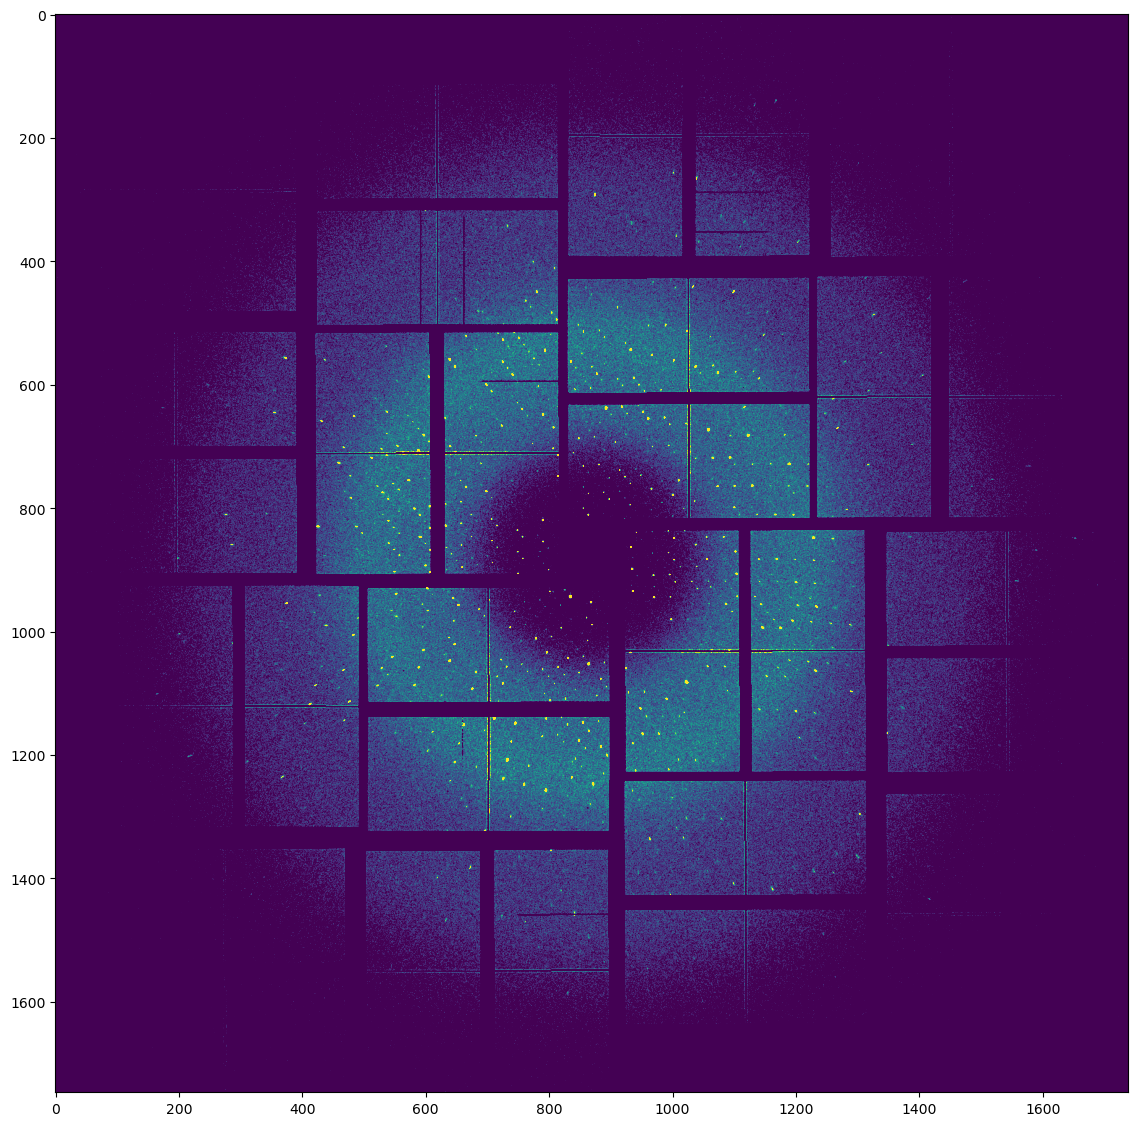

In [140]:
display_img(asmb_img)

In [66]:
# def compute_pixel_maps_from_geometry(geometry):
#     # Assuming geometry is a dictionary similar to your colleague's code structure
    
#     # Initialize the global image map (x_map, y_map) based on the extents of the detector
#     # These extents should be determined from the geometry information
#     max_fs, max_ss = get_detector_extents(geometry)
#     global_image = np.zeros((max_ss + 1, max_fs + 1))
    
#     # Iterate through each panel in the geometry
#     for panel_name, panel_info in geometry["panels"].items():
#         # Compute panel's lab coordinates for each pixel
#         H, W = panel_info["size"]
#         y_range, x_range = np.arange(H), np.arange(W)
#         y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')

#         # Direct calculation of lab coordinates, similar to your colleague's method
#         ss_orient, fs_orient = panel_info['ss'], panel_info['fs']
#         rot_matrix = np.array([ss_orient, fs_orient])
#         rot_matrix = np.linalg.inv(rot_matrix)
#         lab_coords = np.dot(rot_matrix, np.array([y_coords.flatten(), x_coords.flatten()]))

#         # Determine the global positions for the current panel's pixels
#         # This step would incorporate the panel's corner offset into lab_coords
#         # For simplicity, assuming the corner is at (0, 0) in the panel's local coordinate system
#         global_positions = lab_coords + panel_info["corner_offset"].reshape(-1, 1)

#         # Map the panel's pixel values to the global image
#         # Note: You might need to round global_positions to the nearest integer indices
#         for i, pos in enumerate(global_positions.T):
#             global_y, global_x = int(round(pos[0])), int(round(pos[1]))
#             if 0 <= global_y < global_image.shape[0] and 0 <= global_x < global_image.shape[1]:
#                 global_image[global_y, global_x] = panel_info["pixel_values"].flatten()[i]
    
#     return global_image

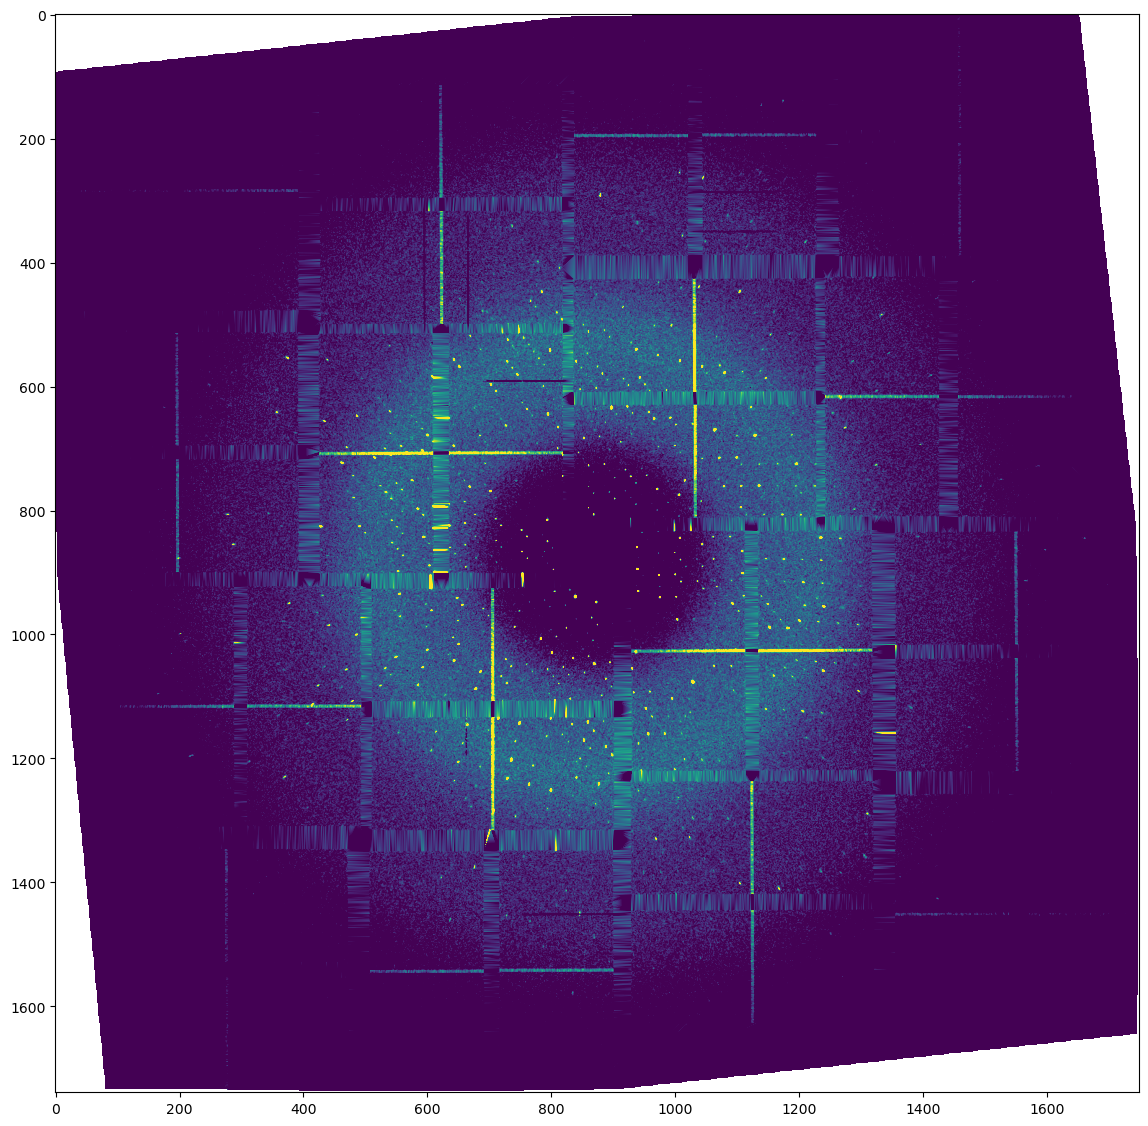

In [67]:
display_img(lab_pixel_values)

/tmp/ipykernel_2446701/2811701141.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pixel_map = np.zeros((*panel_shape, 2), dtype=np.int)  # Maps from cheetah to assembled image


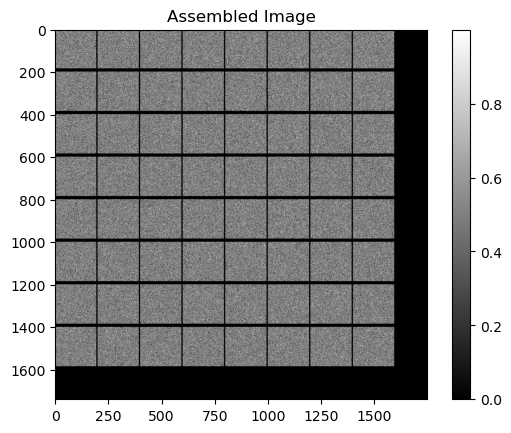

In [41]:
import numpy as np

# Simulate panel data
num_panels = 64
panel_shape = (185, 194)  # Each panel is 185x194 pixels
cheetah_image = np.random.rand(num_panels, *panel_shape)  # Simulated cheetah image data

# Final assembled image shape
assembled_shape = (1739, 1748)

# Simulate orientation vectors and top-left corners for each panel
# For simplicity, assume orientation vectors are unit vectors in the x and y directions
# and top-left corners are evenly spaced
orientation_vectors = np.array([[1, 0], [0, 1]] * num_panels).reshape(num_panels, 2, 2)
top_left_corners = np.array([(i % 8 * 200, i // 8 * 200) for i in range(num_panels)])

# Initialize the pixel map and the final assembled image
pixel_map = np.zeros((*panel_shape, 2), dtype=np.int)  # Maps from cheetah to assembled image
assembled_image = np.zeros(assembled_shape)

# Populate the pixel map and assemble the image
for panel_idx in range(num_panels):
    orientation = orientation_vectors[panel_idx]
    top_left = top_left_corners[panel_idx]
    
    for y in range(panel_shape[0]):
        for x in range(panel_shape[1]):
            # Calculate global (assembled image) coordinates for this pixel
            panel_coords = np.array([y, x])
            global_coords = np.dot(orientation, panel_coords) + top_left
            
            # Update the pixel map (Note: rounding to nearest integer for indexing)
            pixel_map[y, x, :] = np.round(global_coords).astype(int)
            
            # Map the pixel value to the final assembled image
            # Check bounds to avoid indexing errors
            if 0 <= pixel_map[y, x, 0] < assembled_shape[0] and 0 <= pixel_map[y, x, 1] < assembled_shape[1]:
                assembled_image[pixel_map[y, x, 0], pixel_map[y, x, 1]] = cheetah_image[panel_idx, y, x]

# For visualization or verification
import matplotlib.pyplot as plt
plt.imshow(assembled_image, cmap='gray')
plt.title("Assembled Image")
plt.colorbar()
plt.show()


In [220]:
cheetah_converter.geom_dict['panel_orient']

{'q0a0': {'fs': (0.999981, 0.00614), 'ss': (0.00614, -0.999981)},
 'q0a1': {'fs': (0.999981, 0.00614), 'ss': (0.00614, -0.999981)},
 'q0a2': {'fs': (0.999987, 0.005139), 'ss': (0.005139, -0.999987)},
 'q0a3': {'fs': (0.999987, 0.005139), 'ss': (0.005139, -0.999987)},
 'q0a4': {'fs': (0.006472, -0.999979), 'ss': (-0.999979, -0.006472)},
 'q0a5': {'fs': (0.006472, -0.999979), 'ss': (-0.999979, -0.006472)},
 'q0a6': {'fs': (0.006101, -0.999981), 'ss': (-0.999981, -0.006101)},
 'q0a7': {'fs': (0.006101, -0.999981), 'ss': (-0.999981, -0.006101)},
 'q0a8': {'fs': (-0.999996, -0.002888), 'ss': (-0.002888, 0.999996)},
 'q0a9': {'fs': (-0.999996, -0.002888), 'ss': (-0.002888, 0.999996)},
 'q0a10': {'fs': (-1.0, -0.000753), 'ss': (-0.000753, 1.0)},
 'q0a11': {'fs': (-1.0, -0.000753), 'ss': (-0.000753, 1.0)},
 'q0a12': {'fs': (0.003125, -0.999995), 'ss': (-0.999995, -0.003125)},
 'q0a13': {'fs': (0.003125, -0.999995), 'ss': (-0.999995, -0.003125)},
 'q0a14': {'fs': (0.00334, -0.999994), 'ss': (-0

In [133]:
panel_minmax.match('q0a0/min_fs = 0')

<regex.Match object; span=(0, 15), match='q0a0/min_fs = 0'>

In [134]:
res = panel_orient.match('q0a0/fs = +0.006140x +0.999981y')

In [135]:
res.capturesdict()

{'DET_PANEL': ['q0a0'],
 'COORD': ['fs'],
 'VALUE_X': ['+0.006140'],
 'VALUE_Y': ['+0.999981']}

In [218]:
# Go through each line...
geom_dict = {
    'panel_minmax' : {},
    'panel_orient' : {},
}
for geom_key, geom_value in geom_block.items():
    line = f"{geom_key} = {geom_value}"

    # Match a geom object...
    m = panel_minmax.match(line)
    if m is not None:
        # Fetch values...
        capture_dict = m.capturesdict()
        panel = capture_dict['DET_PANEL'][0]
        coord = capture_dict['COORD'][0]
        value = capture_dict['VALUE'][0]

        # Save values...
        if not panel in geom_dict['panel_minmax']:
            geom_dict['panel_minmax'][panel] = {
                'min_fs' : None,
                'min_ss' : None,
                'max_fs' : None,
                'max_ss' : None,
            }
        geom_dict['panel_minmax'][panel][coord] = int(value)
    
    # Match a geom object...
    m = panel_orient.match(line)
    if m is not None:
        # Fetch values...
        capture_dict = m.capturesdict()
        panel = capture_dict['DET_PANEL'][0]
        coord = capture_dict['COORD'][0]
        val_x = capture_dict['VALUE_X'][0]
        val_y = capture_dict['VALUE_Y'][0]

        # Save values...
        if not panel in geom_dict['panel_orient']:
            geom_dict['panel_orient'][panel] = {
                'fs' : None,
                'ss' : None,
            }
        geom_dict['panel_orient'][panel][coord] = (float(val_y), float(val_x))

In [ ]:
geom_dict['panel_minmax']

In [219]:
geom_dict['panel_orient']

{'q0a0': {'fs': (0.999981, 0.00614), 'ss': (0.00614, -0.999981)},
 'q0a1': {'fs': (0.999981, 0.00614), 'ss': (0.00614, -0.999981)},
 'q0a2': {'fs': (0.999987, 0.005139), 'ss': (0.005139, -0.999987)},
 'q0a3': {'fs': (0.999987, 0.005139), 'ss': (0.005139, -0.999987)},
 'q0a4': {'fs': (0.006472, -0.999979), 'ss': (-0.999979, -0.006472)},
 'q0a5': {'fs': (0.006472, -0.999979), 'ss': (-0.999979, -0.006472)},
 'q0a6': {'fs': (0.006101, -0.999981), 'ss': (-0.999981, -0.006101)},
 'q0a7': {'fs': (0.006101, -0.999981), 'ss': (-0.999981, -0.006101)},
 'q0a8': {'fs': (-0.999996, -0.002888), 'ss': (-0.002888, 0.999996)},
 'q0a9': {'fs': (-0.999996, -0.002888), 'ss': (-0.002888, 0.999996)},
 'q0a10': {'fs': (-1.0, -0.000753), 'ss': (-0.000753, 1.0)},
 'q0a11': {'fs': (-1.0, -0.000753), 'ss': (-0.000753, 1.0)},
 'q0a12': {'fs': (0.003125, -0.999995), 'ss': (-0.999995, -0.003125)},
 'q0a13': {'fs': (0.003125, -0.999995), 'ss': (-0.999995, -0.003125)},
 'q0a14': {'fs': (0.00334, -0.999994), 'ss': (-0

In [65]:
geom_block

{'clen': '',
 'photon_energy': '/LCLS/photon_energy_eV',
 'res': '9097.52',
 'adu_per_eV': '0.00338',
 'data': '/entry_1/data_1/data',
 'dim0': '%',
 'dim1': 'ss',
 'dim2': 'fs',
 'mask': '/entry_1/data_1/mask',
 'mask_good': '0x0000',
 'mask_bad': '0xffff',
 'rigid_group_q0': 'q0a0,q0a1,q0a2,q0a3,q0a4,q0a5,q0a6,q0a7,q0a8,q0a9,q0a10,q0a11,q0a12,q0a13,q0a14,q0a15',
 'rigid_group_q1': 'q1a0,q1a1,q1a2,q1a3,q1a4,q1a5,q1a6,q1a7,q1a8,q1a9,q1a10,q1a11,q1a12,q1a13,q1a14,q1a15',
 'rigid_group_q2': 'q2a0,q2a1,q2a2,q2a3,q2a4,q2a5,q2a6,q2a7,q2a8,q2a9,q2a10,q2a11,q2a12,q2a13,q2a14,q2a15',
 'rigid_group_q3': 'q3a0,q3a1,q3a2,q3a3,q3a4,q3a5,q3a6,q3a7,q3a8,q3a9,q3a10,q3a11,q3a12,q3a13,q3a14,q3a15',
 'rigid_group_a0': 'q0a0,q0a1',
 'rigid_group_a1': 'q0a2,q0a3',
 'rigid_group_a2': 'q0a4,q0a5',
 'rigid_group_a3': 'q0a6,q0a7',
 'rigid_group_a4': 'q0a8,q0a9',
 'rigid_group_a5': 'q0a10,q0a11',
 'rigid_group_a6': 'q0a12,q0a13',
 'rigid_group_a7': 'q0a14,q0a15',
 'rigid_group_a8': 'q1a0,q1a1',
 'rigid_group_a

In [ ]:
import sys;
sys.exit(1)

In [125]:
import pickle

path_cheetah_geom = 'cheetah_geom.jungfrau.pickle'
with open(path_cheetah_geom, 'rb') as f:
    cheetah_geom_dict = pickle.load(f)

In [126]:
cheetah_geom_dict

{'p0a0': (0, 0, 255, 255),
 'p0a1': (256, 0, 511, 255),
 'p0a2': (512, 0, 767, 255),
 'p0a3': (768, 0, 1023, 255),
 'p0a4': (0, 256, 255, 511),
 'p0a5': (256, 256, 511, 511),
 'p0a6': (512, 256, 767, 511),
 'p0a7': (768, 256, 1023, 511),
 'p1a0': (0, 512, 255, 767),
 'p1a1': (256, 512, 511, 767),
 'p1a2': (512, 512, 767, 767),
 'p1a3': (768, 512, 1023, 767),
 'p1a4': (0, 768, 255, 1023),
 'p1a5': (256, 768, 511, 1023),
 'p1a6': (512, 768, 767, 1023),
 'p1a7': (768, 768, 1023, 1023),
 'p2a0': (0, 1024, 255, 1279),
 'p2a1': (256, 1024, 511, 1279),
 'p2a2': (512, 1024, 767, 1279),
 'p2a3': (768, 1024, 1023, 1279),
 'p2a4': (0, 1280, 255, 1535),
 'p2a5': (256, 1280, 511, 1535),
 'p2a6': (512, 1280, 767, 1535),
 'p2a7': (768, 1280, 1023, 1535),
 'p3a0': (0, 1536, 255, 1791),
 'p3a1': (256, 1536, 511, 1791),
 'p3a2': (512, 1536, 767, 1791),
 'p3a3': (768, 1536, 1023, 1791),
 'p3a4': (0, 1792, 255, 2047),
 'p3a5': (256, 1792, 511, 2047),
 'p3a6': (512, 1792, 767, 2047),
 'p3a7': (768, 1792, 1

In [124]:
class CheetahConverter:

    def __init__(self, path_cheetah_geom):
        self.path_cheetah_geom = path_cheetah_geom

        with open(self.path_cheetah_geom, 'rb') as handle:
            cheetah_geom_dict = pickle.load(handle)

        cheetah_geom_regex = regex.compile(r"""
            (?x)
            [a-z](?<PANEL>[0-9]+)[a-z](?<ASIC>[0-9]+)
        """)
        cheetah2psana_geom_dict = {}
        for panel_str, (x_min, y_min, x_max, y_max) in cheetah_geom_dict.items():
            match = cheetah_geom_regex.match(panel_str)
            if match is None:
                continue

            capture_dict = match.capturesdict()

            panel_id = capture_dict['PANEL'][0]
            asic_id  = capture_dict['ASIC' ][0]

            x_max += 1
            y_max += 1

            panel_id = int(panel_id)
            if panel_id not in cheetah2psana_geom_dict: cheetah2psana_geom_dict[panel_id] = [x_min, y_min, x_max, y_max]
            panel_x_min, panel_y_min, panel_x_max, panel_y_max = cheetah2psana_geom_dict[panel_id]
            panel_x_min = min(panel_x_min, x_min)
            panel_y_min = min(panel_y_min, y_min)
            panel_x_max = max(panel_x_max, x_max)
            panel_y_max = max(panel_y_max, y_max)
            cheetah2psana_geom_dict[panel_id] = panel_x_min, panel_y_min, panel_x_max, panel_y_max

        self.cheetah_geom_dict       = cheetah_geom_dict
        self.cheetah2psana_geom_dict = cheetah2psana_geom_dict


    def convert_to_cheetah_img(self, img):
        W_cheetah, H_cheetah = list(self.cheetah2psana_geom_dict.values())[-1][-2:]
        cheetah_img = np.zeros((H_cheetah, W_cheetah), dtype = np.float32)

        for panel_id, (x_min, y_min, x_max, y_max) in self.cheetah2psana_geom_dict.items():
            H = y_max - y_min
            W = x_max - x_min
            cheetah_img[y_min:y_max, x_min:x_max] = img[panel_id, 0:H, 0:W]

        return cheetah_img


    def convert_to_psana_img(self, cheetah_img):
        # Figure out channel dimension...
        C = len(self.cheetah2psana_geom_dict)

        # Figure out spatial dimension...
        x_min, y_min, x_max, y_max = self.cheetah2psana_geom_dict[0]
        H = y_max - y_min
        W = x_max - x_min

        # Initialize a zero value image...
        img = np.zeros((C, H, W), dtype = np.float32)

        for panel_id, (x_min, y_min, x_max, y_max) in self.cheetah2psana_geom_dict.items():
            img[panel_id] = cheetah_img[y_min:y_max, x_min:x_max]

        return img


    def convert_to_cheetah_coords(self, peaks_psana_list):
        peaks_cheetah_list = [
            self.convert_to_cheetah_coord(idx_panel, y, x)
            for idx_panel, y, x in peaks_psana_list
        ]

        return peaks_cheetah_list


    def convert_to_cheetah_coord(self, idx_panel, y, x):
        x_min, y_min, x_max, y_max = self.cheetah2psana_geom_dict[idx_panel]

        x += x_min
        y += y_min

        return idx_panel, y, x

In [127]:
path_cheetah_geom = 'cheetah_geom.jungfrau.pickle'
cheetah_converter = CheetahConverter(path_cheetah_geom)

In [130]:
cheetah_converter.cheetah2psana_geom_dict
cheetah_converter.cheetah_geom_dict

{'p0a0': (0, 0, 255, 255),
 'p0a1': (256, 0, 511, 255),
 'p0a2': (512, 0, 767, 255),
 'p0a3': (768, 0, 1023, 255),
 'p0a4': (0, 256, 255, 511),
 'p0a5': (256, 256, 511, 511),
 'p0a6': (512, 256, 767, 511),
 'p0a7': (768, 256, 1023, 511),
 'p1a0': (0, 512, 255, 767),
 'p1a1': (256, 512, 511, 767),
 'p1a2': (512, 512, 767, 767),
 'p1a3': (768, 512, 1023, 767),
 'p1a4': (0, 768, 255, 1023),
 'p1a5': (256, 768, 511, 1023),
 'p1a6': (512, 768, 767, 1023),
 'p1a7': (768, 768, 1023, 1023),
 'p2a0': (0, 1024, 255, 1279),
 'p2a1': (256, 1024, 511, 1279),
 'p2a2': (512, 1024, 767, 1279),
 'p2a3': (768, 1024, 1023, 1279),
 'p2a4': (0, 1280, 255, 1535),
 'p2a5': (256, 1280, 511, 1535),
 'p2a6': (512, 1280, 767, 1535),
 'p2a7': (768, 1280, 1023, 1535),
 'p3a0': (0, 1536, 255, 1791),
 'p3a1': (256, 1536, 511, 1791),
 'p3a2': (512, 1536, 767, 1791),
 'p3a3': (768, 1536, 1023, 1791),
 'p3a4': (0, 1792, 255, 2047),
 'p3a5': (256, 1792, 511, 2047),
 'p3a6': (512, 1792, 767, 2047),
 'p3a7': (768, 1792, 1